In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
real_states = np.array([1., 2., 3., 4.], dtype=np.float32)
# We fix the initial states for comparison purpose. 
# The following states makes the greedy learning hard. 
init_states = np.array([-100, -200, -300, -400], dtype=np.float32)
batch_size = 100 
train_samples = 100000 

In [3]:
def train(batch_size, train_samples, real_states, init_states, epsilon):
    num_states = len(real_states)

    with tf.Graph().as_default():
      # Holds the estimate of the state
      state = tf.get_variable('state', shape=[num_states], 
                              initializer=(
                                  tf.constant_initializer(init_states) if 
                                  init_states is not None else None))

      # Generate the "explore" probability for current batch.
      probabiliy = tf.random_uniform(shape=[batch_size])
      # Cast to int, 1: should explore 0: should be greedy.
      explore = tf.cast(tf.less(probabiliy, epsilon), tf.int32)
      
      # Find the current "best" state with greatest reward.
      greedy_max_reward_state = tf.tile(
          ([tf.cast(tf.argmax(state),  dtype=tf.int32)]), [batch_size])
      # Generate random state to explore.
      random_state_to_explore = tf.random_uniform(
          shape=[batch_size], maxval=num_states, dtype=tf.int32)

      # Get the current state to try and calculate estimated reward.
      current_state = (
          explore * random_state_to_explore + (1 - explore) * greedy_max_reward_state)
      
      current_estimated_reward = tf.gather(state, current_state)
        
      # Get the real state from environment.
      real_reward = tf.gather(real_states, current_state)

      loss = tf.losses.mean_squared_error(real_reward, current_estimated_reward)

      opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
      train_op = [opt.minimize(loss)]
      
      mean_reward_update_op, mean_reward = tf.metrics.mean(real_reward)
      train_op.append(mean_reward_update_op)

      with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        # Adds the initialized state. reward and loss are meaningless.
        rows = []
        row = list([0, 0, 0]) + list(sess.run(state))
        rows.append(row)
        
        for i in range(train_samples // batch_size):
          t = sess.run(train_op + [state, loss])
          if i % 100 == 0:
            mean_reward_value = sess.run(mean_reward)
            loss_value = t[3]
            row = [(i+1) * batch_size, mean_reward_value, loss_value]
            row.extend(t[2])
            rows.append(row)
            
        # Format as DataFrames
        columns = ['samples trained', 'mean_reward', 'loss']
        for i in range(num_states):
            columns.append('state_{}'.format(i+1))
        df = pd.DataFrame(rows, columns=columns)
        return df

df = train(
    batch_size=batch_size, 
    train_samples=train_samples, 
    real_states=real_states,
    init_states=init_states,
    epsilon=0.3)
df

,samples trained,mean_reward,loss,state_1,state_2,state_3,state_4
0,0,0.000000,0.000000e+00,-100.000000,-200.000000,-300.000000,-400.000000
1,100,1.290000,2.203416e+04,-82.223694,-198.787979,-297.576050,-395.959930
2,10100,1.325000,1.227812e+03,0.999988,-41.087456,-64.990448,-80.265465
3,20100,1.373333,5.594143e+01,0.999988,-7.590217,-11.768476,-16.420914
4,30100,1.390000,2.102700e+00,0.999988,-0.241363,-0.035016,-0.400364
5,40100,1.804000,6.373277e-02,0.999988,1.478378,2.312275,3.999952
6,50100,2.098333,1.633722e-03,0.999988,1.889018,2.850969,3.999952
7,60100,2.318571,1.307245e-04,0.999988,1.974587,2.965799,3.999952
8,70100,2.465000,6.513486e-06,0.999988,1.994365,2.992139,3.999952
9,80100,2.586667,3.146497e-07,0.999988,1.998740,2.998271,3.999952


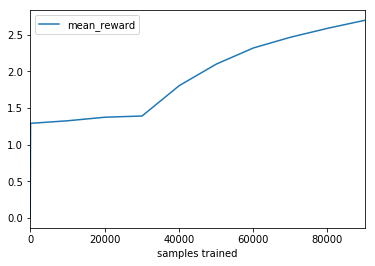

In [4]:
df.plot(x='samples trained', y='mean_reward')

In [5]:
def train_with_learning_schedule(
        batch_size, train_samples, real_states, init_states, explore_samples, epsilon):
    num_states = len(real_states)

    with tf.Graph().as_default():
      # Holds the estimate of the state
      state = tf.get_variable('state', shape=[num_states], 
                              initializer=(
                                  tf.constant_initializer(init_states) if 
                                  init_states is not None else None))

      # Generate the "explore" probability for current batch.
      probabiliy = tf.random_uniform(shape=[batch_size])
      # Cast to int, 1: should explore 0: should be greedy.
      explore = tf.cast(tf.less(probabiliy, epsilon), tf.int32)
      
      # Find the current "best" state with greatest reward.
      greedy_max_reward_state = tf.tile(
          ([tf.cast(tf.argmax(state),  dtype=tf.int32)]), [batch_size])
      # Generate random state to explore.
      random_state_to_explore = tf.random_uniform(
          shape=[batch_size], maxval=num_states, dtype=tf.int32)
      
      tf.train.create_global_step()
      # Get the current state to try and calculate estimated reward.
      # For first `explore_samples`, we only do explore.
      current_state = (
          tf.cond(tf.less(tf.train.get_global_step(), explore_samples // batch_size),
                  lambda: random_state_to_explore,
                  lambda: (explore * random_state_to_explore + 
                           (1 - explore) * greedy_max_reward_state)))
      
      current_estimated_reward = tf.gather(state, current_state)
        
      # Get the real state from environment.
      real_reward = tf.gather(real_states, current_state)

      loss = tf.losses.mean_squared_error(real_reward, current_estimated_reward)

      opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
      train_op = [opt.minimize(loss, global_step=tf.train.get_global_step())]
      
      mean_reward_update_op, mean_reward = tf.metrics.mean(real_reward)
      train_op.append(mean_reward_update_op)

      with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        # Adds the initialized state. reward and loss are meaningless.
        rows = []
        row = list([0, 0, 0]) + list(sess.run(state))
        rows.append(row)
        
        for i in range(train_samples // batch_size):
          t = sess.run(train_op + [state, loss])
          if i % 100 == 0:
            mean_reward_value = sess.run(mean_reward)
            loss_value = t[3]
            row = [(i+1) * batch_size, mean_reward_value, loss_value]
            row.extend(t[2])
            rows.append(row)
            
        # Format as DataFrames
        columns = ['samples trained', 'mean_reward', 'loss']
        for i in range(num_states):
            columns.append('state_{}'.format(i+1))
        df = pd.DataFrame(rows, columns=columns)
        return df

df = train_with_learning_schedule(
    batch_size=batch_size, 
    train_samples=train_samples, 
    real_states=real_states,
    init_states=init_states,
    explore_samples=batch_size*100,
    epsilon=0.2)
df

,samples trained,mean_reward,loss,state_1,state_2,state_3,state_4
0,0,0.000000,0.000000e+00,-100.000000,-200.000000,-300.000000,-400.000000
1,100,2.480000,8.650448e+04,-95.555923,-191.919861,-284.244324,-374.143555
2,10100,3.190000,3.697606e+00,0.332574,0.707109,1.274851,2.371320
3,20100,3.380000,4.560100e-02,0.742254,1.521470,2.340397,3.999945
4,30100,3.475000,4.653852e-03,0.905923,1.827814,2.750333,3.999945
5,40100,3.496000,4.704354e-04,0.965464,1.939407,2.907402,3.999945
6,50100,3.530000,6.073192e-05,0.988042,1.977750,2.968454,3.999945
7,60100,3.554286,1.384018e-05,0.995446,1.992250,2.988418,3.999945
8,70100,3.558750,1.153659e-06,0.998322,1.997178,2.995871,3.999945
9,80100,3.588889,1.932440e-07,0.999402,1.999045,2.998401,3.999945


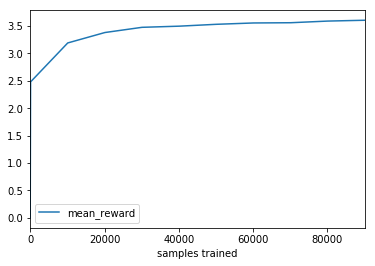

In [6]:
df.plot(x='samples trained', y='mean_reward')